In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.utils.data as data
from torch import nn, optim
from torch.nn import functional as F
import umap
import matplotlib.pyplot as plt
from pyHGT.model import GNN, GNN_from_raw
import scanpy as sp
import pandas as pd
import networkx as nx
from community import community_louvain


In [2]:
adata=sp.read_h5ad("/users/PCON0022/haocheng/Basu_lab/combined_SCB01S5.h5ad")
adata

AnnData object with n_obs × n_vars = 11107 × 22905
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'count.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters', 'X', 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [3]:
# adata.obs['ann_level_3_pred'].value_counts().plot(kind='barh')

In [4]:
celltype_names=list(adata.obs['ann_level_3_pred'].value_counts().index)
print("celltype names:",celltype_names)
cell_cluster_indexs=[]
indexs=np.arange(adata.shape[0])
for celltype_name in celltype_names:
    cell_cluster_indexs.append(indexs[adata.obs['ann_level_3_pred']==celltype_name])
    
print("cluster 数量：",len(cell_cluster_indexs))

# 存储了每个cell的cluster标签
cluster_index=adata.obs['ann_level_3_pred'].cat.codes.tolist()
cluster_index=torch.tensor(cluster_index)
# 对应的cluster名称
cluster_names=list(adata.obs['ann_level_3_pred'].cat.categories)

celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Secretory', 'Fibroblasts', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
cluster 数量： 21


In [5]:
def umapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for cluster,label in zip(clusters,labels):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.5,s=5,label=label)
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
            

In [6]:
# umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_indexs,labels=celltype_names)

In [7]:
# plt.figure(figsize=(6,6),dpi=300)
# sns.heatmap(adata.X.toarray(),cmap='Greys')

In [8]:
markers=pd.read_csv("combined_senescence_list.csv",header=None)
markers1=markers[0][markers[0].notnull()]
markers2=markers[1][markers[1].notnull()]
markers3=markers[2][markers[2].notnull()]
markers4=markers[3][markers[3].notnull()]

print(len(markers1),len(markers2),len(markers3),len(markers4))

markers_set=set(list(markers1)+list(markers2)+list(markers3)+list(markers4))
print(len(markers_set))

sp.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata

126 78 145 84
380


AnnData object with n_obs × n_vars = 11107 × 22905
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'count.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters', 'X', 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

In [9]:
highly_genes=list(adata.var[adata.var['highly_variable']==True].index)
print(len(highly_genes))

# 去除其中的老化基因，然后再把老化基因append到最后
highly_genes=list(set(highly_genes)-markers_set)
print(len(highly_genes))

genes=highly_genes+list(markers_set)
print(len(genes))

# 注意到下面的3622，有些marker是没有的
new_data=adata[:,adata.var.name.isin(genes)]
new_data

3370
3260
3640


View of AnnData object with n_obs × n_vars = 11107 × 3622
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'count.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters', 'X', 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

In [10]:
# device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

自编码器生成初始embedding

In [11]:
class AE(nn.Module):
    def __init__(self, dim, emb_dim=256):
        super(AE, self).__init__()
        self.dim = dim
        self.fc1 = nn.Linear(dim, 512)
        self.fc2 = nn.Linear(512, emb_dim)
        self.fc3 = nn.Linear(emb_dim, 512)
        self.fc4 = nn.Linear(512, dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return F.relu(self.fc2(h1))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.relu(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x.view(-1, self.dim))
        return self.decode(z), z

def reduction_AE(gene_cell,device):
    gene = torch.tensor(gene_cell, dtype=torch.float32).to(device)
    if gene_cell.shape[0] < 5000:
        ba = gene_cell.shape[0]
    else:
        ba = 5000
    gene_embed=train_AE(gene,ba,device)

    if gene_cell.shape[1] < 5000:
        ba = gene_cell.shape[1]
    else:
        ba = 5000
    cell = torch.tensor(np.transpose(gene_cell),
                        dtype=torch.float32).to(device)
    cell_embed=train_AE(cell,ba,device)
    return gene_embed,cell_embed


def train_AE(feature,ba,device,alpha=0.5, is_init=False):
    model = AE(dim=feature.shape[1]).to(device)
    loader = data.DataLoader(feature, ba)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    loss_func = nn.MSELoss()
    EPOCH_AE = 2000
    for epoch in range(EPOCH_AE):
        embeddings = []
        # loss_ls=[]
        for _, batch_x in enumerate(loader)	:
            decoded, encoded = model(batch_x)
            loss = loss_func(batch_x, decoded)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            embeddings.append(encoded)
        #     loss_ls.append(loss.item())
        # scheduler.step(np.mean(loss_ls))
    print('Epoch :', epoch, '|', 'train_loss:%.12f' % loss.data)
    return torch.cat(embeddings)


gene_cell=new_data.X.toarray().T
retrain=False
if retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    print(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,'./gene.emb')
    torch.save(cell_embed,'./cell.emb')
else:
    gene_embed=torch.load('./gene.emb')
    cell_embed=torch.load('./cell.emb')

In [12]:
# umapPlot(cell_embed.cpu().detach().numpy(),reduce=True,
#          clusters=cell_cluster_indexs,labels=celltype_names)

build graph

In [13]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected


g_index,c_index = np.nonzero(gene_cell)
print('the number of edges:',len(g_index))
# 加上偏移量作为cell的节点标号
c_index += gene_cell.shape[0]
edge_index=torch.tensor([g_index, c_index], dtype=torch.long)
print('edge index: ',edge_index.shape)
x=torch.cat([gene_embed,cell_embed]).detach()
print('node feature: ',x.shape)

edge_index=to_undirected(edge_index)
graph = Data(x=x, edge_index=edge_index)

the number of edges: 2083091
edge index:  torch.Size([2, 2083091])
node feature:  torch.Size([14729, 256])


In [14]:
print(graph)
print(graph.is_directed())

Data(x=[14729, 256], edge_index=[2, 4166182])
False


In [15]:
from torch_geometric.utils import k_hop_subgraph

def sub_sampling(graph,num_sen=5,num_nonsen=5):
    ls1=np.random.choice(range(3260,3622),num_sen,replace=False)
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    # y里面的指定了前10个embedding中哪些是老化基因的embedding
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=res[2]<5)
    return sampled_graph


def plot_subgraph(sampled_graph):
    G = nx.Graph()

    G.add_nodes_from(range(10), layer=0)
    G.add_nodes_from(range(10,sampled_graph.x.shape[0]), layer=1)
    G.add_edges_from(sampled_graph.edge_index.T.tolist())

    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color='red', with_labels=True)
    


graph=graph.to(device)
cluster_index=cluster_index.to(device)


# plot_subgraph(sampled_graph)

使用GAT计算Attention和embedding变换

In [16]:
from torch_geometric.nn import Sequential, GATConv, JumpingKnowledge
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn.models import InnerProductDecoder, GAE, VGAE

class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(256,256)
        self.linear2 = Linear(256,256)
        
        # 默认有自环，所以attention里面也有自环的attention
        # 为了后面的处理，这里去掉自环
        self.conv1 = GATConv(256,256,add_self_loops=False)
        self.conv2 = GATConv(256,256,add_self_loops=False)
        
        self.act = torch.nn.CELU()

    def forward(self, graph, split=10):
        x, edge_index = graph.x, graph.edge_index
        
        x=torch.cat([F.relu(self.linear1(x[:split,:])),
                     F.relu(self.linear2(x[split:,:]))])

        x = self.conv1(x, edge_index)
#         x = F.relu(x)
        x = self.act(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.act(x)
        

        return x
    
    def get_att(self,graph, split=10):
        x, edge_index = graph.x, graph.edge_index
        
        x=torch.cat([F.relu(self.linear1(x[:split,:])),
                     F.relu(self.linear2(x[split:,:]))])

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x, att = self.conv2(x, edge_index,return_attention_weights=True)

        return x, att
    

class SenGAE(GAE):
    def __init__(self):
        super(SenGAE, self).__init__(encoder=Encoder(),
                                     decoder=InnerProductDecoder())

    def forward(self, graph, split=10):
        z = self.encode(graph)
        # adj_pred = self.decoder(z)
        return z


In [17]:
# model = SenGAE().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 'min', factor=0.5, patience=10, verbose=True)

# # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99,
# #                                 weight_decay=1e-4)

# model.train()
# for epoch in range(20):
#     epoch_ls=[]
#     print('Epoch: ', epoch)
#     num_subgraphs=50
#     jobs=[]
#     for _ in range(num_subgraphs):
#         sampled_graph=sub_sampling(graph)
#         if np.any(np.isnan(sampled_graph.x.cpu().numpy())):
#             print('NaN!')    
#         jobs.append(sampled_graph)
#     for sampled_graph in jobs:
#         sampled_graph = sampled_graph.to(device)
#         loss_ls=[]
        
#         for epoch in range(5):
#             optimizer.zero_grad()  
#             z = model(sampled_graph)
#             loss=model.recon_loss(z,sampled_graph.edge_index)
#             loss_ls.append(loss.item())
#             loss.backward()
#             optimizer.step() 
# #         print('    subgraph:',np.mean(loss_ls))
#         epoch_ls.append(np.mean(loss_ls))
#     print('mean loss: ',np.mean(epoch_ls))
#     scheduler.step(np.mean(epoch_ls))
    
# torch.save(model,'./model.pt')

In [18]:
model=torch.load('./model.pt')

In [19]:
# 输入整个大图        
# model.eval()
# model=model.to('cpu')
# graph=graph.to('cpu')
# recon=model(graph)
                  
# # gpu_tracker.track()     

# umapPlot(recon[3622:,:].detach().cpu(),reduce=True,
#          clusters=cell_cluster_indexs,labels=celltype_names)

直接使用现成的celltype，跳过clustering过程

In [20]:
def sub_sampling_sen(graph,cluster_index, num_sen=5,num_nonsen=5):
    ls1=np.random.choice(range(3260,3622),num_sen,replace=False)
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    
    cell_index=res[0][num_sen+num_nonsen:].detach().cpu()
    clusters=cluster_index[cell_index-3622]
    # y里面的指定了前10个embedding中哪些是老化基因的embedding
    # y里面10以后指定了细胞的cluster标签
    lables=torch.cat([res[2]<5,clusters])
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=lables)
    return sampled_graph
    
    
# num_subgraphs=100
# jobs=[]
# for _ in range(num_subgraphs):
#     sampled_graph=sub_sampling_sen(graph,cluster_index)
#     jobs.append(sampled_graph)

def get_sencell_index(sampled_graph,edge,edge_att):
    # 基于attention的到sencell
    sen_gene_index=torch.arange(10)[sampled_graph.y[:10]]

    # f, ax = plt.subplots(1,5,figsize=(10,2))

    res=[]
    for j,i in enumerate(sen_gene_index):
        atts=edge_att[edge[0]==i]
        # attention 分布
        # sns.histplot(atts.detach().cpu(),ax=ax[j])
        cell_index=edge[1][edge[0]==i]
        # 保留attention>=0.5的cell
        cell_index=cell_index[atts.T[0]>=0.7].detach().cpu()
        res.append(cell_index)

    results=list(set(torch.cat(res).tolist()))
    # print('sencell num: ',len(results))
    return results

def get_nonsencell_index(sencell_index,sampled_graph):
    cell_indexs=set(list(range(10,sampled_graph.x.shape[0])))
    sencell_indexs=set(sencell_index)
    nonsencell_indexs=cell_indexs-sencell_indexs
    
    return list(nonsencell_indexs)



In [21]:
class EncoderLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(256,256)
        self.linear2 = Linear(256,256)
        self.linear3 = Linear(256,256)
        self.linear4 = Linear(256,256)
        # encoder_layer = torch.nn.TransformerEncoderLayer(d_model=128, nhead=8)
        # self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, 
        #                                                        num_layers=2)
        self.act = torch.nn.CELU()
        self.levels = torch.nn.Parameter(torch.tensor([-3.0, -1, 1, 3.0]), requires_grad=False)
#         self.levels = torch.tensor([-3.0, -1, 1, 3.0])
    

    def forward(self, x):      
        x=self.linear2(self.act(self.linear1(x)))
        x=self.linear4(self.act(self.linear3(x)))
#         print(x.shape)
#         res=torch.squeeze(self.transformer_encoder(torch.unsqueeze(x,0)))
#         print(res.shape)
        return x
    
    def getClusters(self,sampled_graph,sencell_index,nonsencell_index):
        # 计算cluster_index和sencell_index的映射表
        clusters=sampled_graph.y[sencell_index]        
        cluster_set=set(clusters.cpu().tolist())
        all_clusters={}
        for i in cluster_set:
            all_clusters[i]=sencell_index[clusters==i]
        sen_cluster_index=cluster_set
        
        # 还要计算cluster_index和nonsencell_index大的映射表
        clusters=sampled_graph.y[nonsencell_index]
        cluster_set=set(clusters.cpu().tolist())
        for i in cluster_set:
            # 注意到簇的数量不要大于100！
            # 非老化细胞的簇减去100
            all_clusters[i-100]=nonsencell_index[clusters==i]
            
        nonsen_cluster_index=cluster_set
        # all_cluster里面value的index的0-10是基因的
        # 考虑到有的簇里面并不是老化细胞和非老化细胞都有，所以这里返回cluster的index用于后面
        return all_clusters,(sen_cluster_index,nonsen_cluster_index)
    
    def getPrototypeEmbedding(self,outs,all_clusters):
        prototype={}
        for i,j in all_clusters.items():
            # 这里要减10
            prototype[i]=torch.mean(outs[j-10],0)
        
        return prototype
        
        
    def calculateDistanceMatrix(self,prototype,outs):
        # 计算每个cell和prototype之间的距离
        # 得到n*K的矩阵
        results=[]
        # 存储cluster的名称
        cluster_names=[]
        for i,j in prototype.items():
            distances=torch.cdist(outs, j.view(1,-1), p=2)
            results.append(distances)
            cluster_names.append(i)
        
        distance_matrix=torch.cat(results,1)
        
        # Standardization
        mean=torch.mean(distance_matrix)
        std=torch.std(distance_matrix)
        distance_matrix=(distance_matrix-mean)/std        
        # plot
#         sns.displot(distance_matrix.view(-1).detach().cpu())
        # print(distance_matrix)
        return distance_matrix, cluster_names
    
    def getDifferentDistance(self, all_clusters, distance_matrix, indexs, cluster_names):
        sen_cluster_index,nonsen_cluster_index=indexs
        distances=[]
        for cluster in sen_cluster_index:
            col_index=cluster_names.index(cluster)
            # d1老化细胞簇内细胞和簇心的距离
            # 这里要减10
            d1=distance_matrix[all_clusters[cluster]-10,col_index]
            # d2是这一簇的老化细胞的簇心和其它簇的老化细胞之间的距离
            d2=[]
            # 这里考虑的是其它有老化细胞的簇
            for other_cluster in sen_cluster_index:
                if cluster!=other_cluster:
                    # 这里要减10
                    d2.append(distance_matrix[all_clusters[other_cluster]-10,col_index])
            # 可能存在只有一个老化细胞的情况
            if len(d2)==0:
                d2=torch.tensor([]).to(device)
            else:
                d2=torch.cat(d2)  
            # d3是这一簇内部老化细胞簇心和非老化细胞之间的距离
            # 可能有一簇全是老化细胞
            if cluster-100 in all_clusters:
                d3=distance_matrix[all_clusters[cluster-100]-10,col_index]
            else:
                d3=torch.tensor([]).to(device)
            # d4是老化细胞簇心和其它簇非老化细胞之间的距离
            d4=[]
            # 这里考虑的是其它有非老化细胞的簇
            for other_cluster in nonsen_cluster_index:
                if cluster!=other_cluster:
                    # 这里要减10
                    d4.append(distance_matrix[all_clusters[other_cluster-100]-10,col_index])
            d4=torch.cat(d4)
            distances.append([d1,d2,d3,d4])
        
        # print(distances)
        return distances
    
    def plotdistance(self,distances):
        d1,d2,d3,d4=distances
        plt.figure()
        sns.histplot(d1.detach().cpu(),alpha=0.5,color='red',label='d1')
        sns.histplot(d2.detach().cpu(),alpha=0.5,color='green',label='d2')
        sns.histplot(d3.detach().cpu(),alpha=0.5,color='black',label='d3')
        sns.histplot(d4.detach().cpu(),alpha=0.5,color='blue',label='d4')
        plt.ylim([0, 100])
        plt.legend()
    
    def getMLDloss(self,distances,plot=False):
        if plot:
            self.plotdistance(distances[0])
        
        results=0
        
        for cluster_distance in distances:
#             print(cluster_distance)
            if len(cluster_distance[0])!=0: 
                results+=(cluster_distance[0]-self.levels[0]).square().sum().sqrt()
            if len(cluster_distance[1])!=0: 
                results+=(cluster_distance[1]-self.levels[1]).square().sum().sqrt()
            if len(cluster_distance[2])!=0:
                results+=(cluster_distance[2]-self.levels[2]).square().sum().sqrt()
            if len(cluster_distance[3])!=0: 
                results+=(cluster_distance[3]-self.levels[3]).square().sum().sqrt()
            
        return results/len(distances)
    
    def prototypeLoss(self,distances):
        results=0
        for cluster_distance in distances:
            results+=cluster_distance[0].square().sum().sqrt()
            
        return results/len(distances)
    
    def loss(self, outs, graph, sencell_index,nonsencell_index,plot=False):
        all_clusters,indexs=self.getClusters(graph, sencell_index,nonsencell_index)
        # print("cluster index (sen and nonsen): ",indexs)
        # 存储prototype的embedding
        prototype=self.getPrototypeEmbedding(outs,all_clusters)
#         print(prototype)
        distance_matrix, cluster_names=self.calculateDistanceMatrix(prototype,outs)
        # print("distance_matrix.shape: ",distance_matrix.shape)
        # print("cluster_names: ",cluster_names)
        # sns.heatmap(distance_matrix.detach().cpu().numpy(),cmap='Greys')
        distances=self.getDifferentDistance(all_clusters,distance_matrix,indexs,cluster_names)
        loss=self.getMLDloss(distances,plot)
        
        return loss

In [22]:
# # device='cpu'
# cellmodel=EncoderLinear().to(device)
# # optimizer = torch.optim.Adam(cellmodel.parameters(), lr=0.0001, 
# #                              weight_decay=1e-3)
# optimizer = torch.optim.RMSprop(cellmodel.parameters(), lr=0.1, alpha=0.5,
#                                 weight_decay=1e-4)

# cellmodel.train()
# model.eval()

# num_subgraphs=75
# graph=graph.to(device)

    
# # torch.save(jobs,'./jobs.file')

# # jobs=torch.load('./jobs.file')

# print('subgraph sampling end')
# for epoch in range(10):
#     print('epoch: ', epoch)
#     jobs=[]
#     for _ in range(num_subgraphs):
#         sampled_graph=sub_sampling_sen(graph,cluster_index)
#         jobs.append(sampled_graph)
#     epoch_loss=[]
#     for sampled_graph in jobs:
#         z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
#         sampled_graph.x=z.detach()

#         # 这个index里面0-9是基因的
#         sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
#         # 这个index里面0-9是基因的
#         nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)
#         sencell_index=torch.tensor(sencell_index).to(device)
#         nonsencell_index=torch.tensor(nonsencell_index).to(device)

#         sampled_graph = sampled_graph.to(device)

#         plot=False
#         loss_ls=[]
#         for epoch in range(10):
#             optimizer.zero_grad()
#             outs = cellmodel(sampled_graph.x[10:])
#             loss=cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot)
#             loss_ls.append(loss.item())
#             loss.backward()
#             optimizer.step()
#         epoch_loss.append(np.mean(loss_ls))
#     print("loss: ",np.mean(epoch_loss))
    
# torch.save(cellmodel,'./cellmodel.pt')

In [23]:
cellmodel=torch.load('./cellmodel.pt')

In [24]:
'''
model.eval()
cellmodel.eval()
jobs=torch.load('./jobs.file')
for sampled_graph in jobs:
    z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
    sampled_graph.x=z.detach()

    # 这个index里面0-9是基因的
    sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
    # 这个index里面0-9是基因的
    nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)
    sencell_index=torch.tensor(sencell_index).to(device)
    nonsencell_index=torch.tensor(nonsencell_index).to(device)

    sampled_graph = sampled_graph.to(device)
    outs = cellmodel(sampled_graph.x[10:])
    plot=True
    cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot)
    break
'''

"\nmodel.eval()\ncellmodel.eval()\njobs=torch.load('./jobs.file')\nfor sampled_graph in jobs:\n    z,(edge,edge_att)=model.encoder.get_att(sampled_graph)\n    sampled_graph.x=z.detach()\n\n    # 这个index里面0-9是基因的\n    sencell_index=get_sencell_index(sampled_graph,edge,edge_att)\n    # 这个index里面0-9是基因的\n    nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)\n    sencell_index=torch.tensor(sencell_index).to(device)\n    nonsencell_index=torch.tensor(nonsencell_index).to(device)\n\n    sampled_graph = sampled_graph.to(device)\n    outs = cellmodel(sampled_graph.x[10:])\n    plot=True\n    cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot)\n    break\n"

In [25]:
# for name, parms in cellmodel.named_parameters():
#     print('-->name:', name)
#     print('-->para:', parms)
#     print('-->grad_requirs:',parms.requires_grad)
#     print('-->grad_value:',parms.grad)

In [36]:
# 模型训练完成后，将整个图输入进去
model.eval()
cellmodel.eval()

def samlping_sengraph(graph):
    sen_index=torch.arange(3260,3622)
    gene_num=3622-3260
    res=k_hop_subgraph(sen_index,1,graph.edge_index,relabel_nodes=True)
    
    cell_index=res[0][gene_num:].detach().cpu()
    clusters=cluster_index[cell_index-3622].cpu()
    labels=torch.cat([torch.ones(gene_num)==1,clusters])
    sampled_graph=Data(x=graph.x[res[0]],edge_index=res[1],
                       y=labels)
    return sampled_graph

def get_sencell_index1(sampled_graph,edge,edge_att,split=3622-3260):
    # 基于attention的到sencell
    sen_gene_index=torch.arange(split)[sampled_graph.y[:split]]

    # f, ax = plt.subplots(1,5,figsize=(10,2))

    res=[]
    for j,i in enumerate(sen_gene_index):
        atts=edge_att[edge[0]==i]
        # attention 分布
        # sns.histplot(atts.detach().cpu(),ax=ax[j])
        cell_index=edge[1][edge[0]==i]
        # 保留attention>=0.5的cell
        cell_index=cell_index[atts.T[0]>=0.1].detach().cpu()
        res.append(cell_index)

    results=list(set(torch.cat(res).tolist()))
    # print('sencell num: ',len(results))
    return results

def get_nonsencell_index1(sencell_index,sampled_graph,split=3622-3260):
    cell_indexs=set(list(range(split,sampled_graph.x.shape[0])))
    sencell_indexs=set(sencell_index)
    nonsencell_indexs=cell_indexs-sencell_indexs
    
    return list(nonsencell_indexs)

sampled_graph=samlping_sengraph(graph)

z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
sampled_graph.x=z.detach()
# 这个index里面0-9是基因的
sencell_index=get_sencell_index1(sampled_graph,edge,edge_att)
# 这个index里面0-9是基因的
nonsencell_index=get_nonsencell_index1(sencell_index, sampled_graph)
print(sencell_index,nonsencell_index)
sencell_index=torch.tensor(sencell_index).to(device)
nonsencell_index=torch.tensor(nonsencell_index).to(device)

sampled_graph = sampled_graph.to(device)

plot=False
split=3622-3260
outs = cellmodel(sampled_graph.x[split:])
# loss=cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot)


[10754, 515, 5123, 10757, 5126, 10250, 1551, 3600, 1553, 7696, 11284, 4120, 1049, 3100, 8221, 2590, 1570, 10786, 5158, 566, 4666, 2109, 5181, 2112, 3142, 2119, 3656, 9288, 7246, 2128, 5713, 8272, 595, 2644, 2647, 6746, 603, 10843, 6749, 1632, 3680, 9829, 4201, 2669, 10864, 2674, 1652, 9847, 10360, 4730, 6778, 9338, 8317, 3198, 7807, 6786, 7299, 8322, 2694, 1671, 6791, 3211, 10891, 7311, 7313, 658, 660, 4761, 3744, 4768, 3235, 2731, 3756, 10423, 3771, 6854, 10438, 712, 11464, 1229, 3790, 3284, 2774, 6359, 8412, 2781, 8928, 1761, 9952, 10465, 3812, 1256, 6888, 3819, 10987, 1261, 9454, 752, 3825, 7409, 1267, 7929, 7930, 3836, 3837, 5885, 9984, 773, 3333, 6917, 4362, 11018, 4365, 4878, 5904, 9492, 10518, 11043, 10020, 2341, 1319, 4392, 6446, 3888, 8498, 3381, 4406, 7477, 4413, 7489, 1346, 3906, 9538, 9546, 4428, 1870, 8014, 9551, 4945, 8017, 10062, 10067, 10579, 8031, 9055, 1378, 9058, 9064, 7530, 9578, 10606, 4978, 4467, 7027, 886, 11127, 3963, 7556, 7054, 1937, 1940, 1941, 5536, 5543, 45

In [33]:
1-

SyntaxError: invalid syntax (2847093696.py, line 1)

0.0

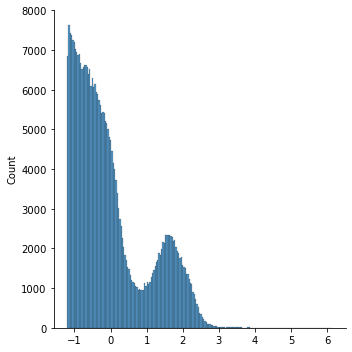

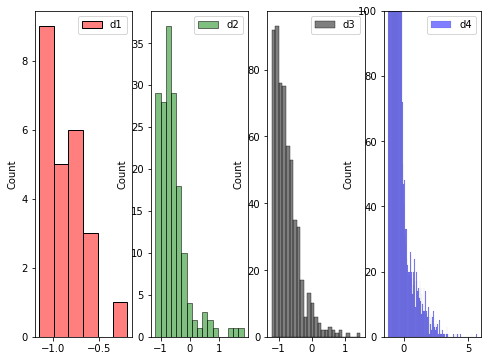

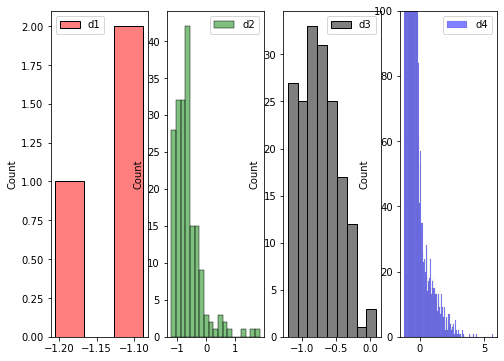

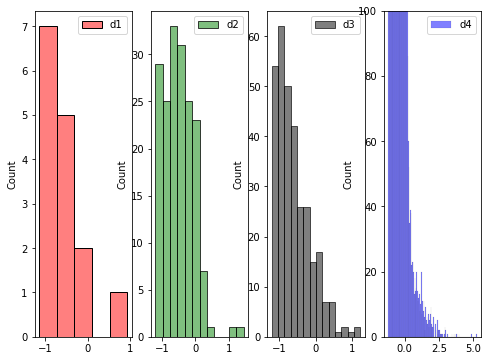

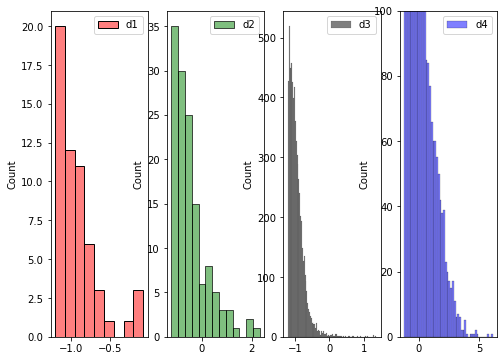

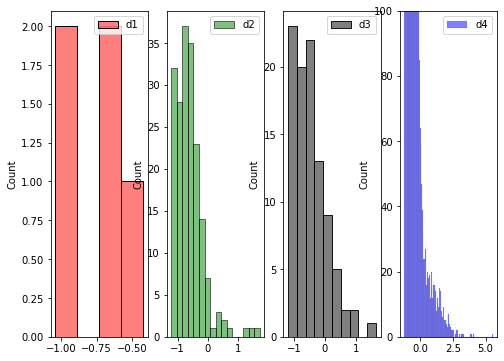

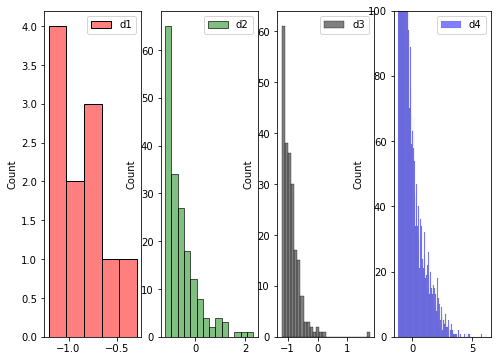

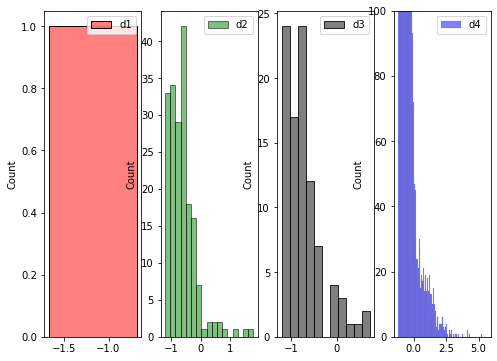

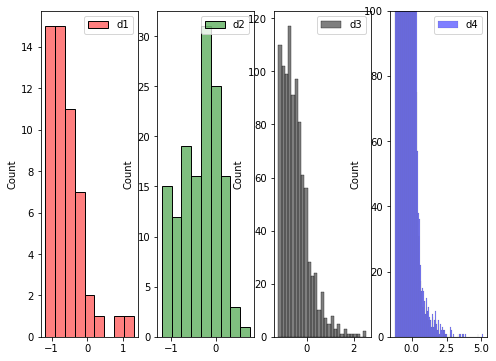

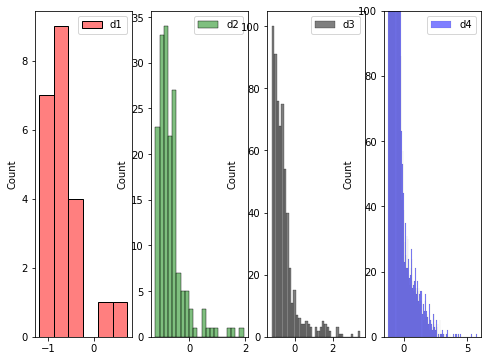

In [39]:
class Plots():
    def getClusters(self,sampled_graph,sencell_index,nonsencell_index):
        # 计算cluster_index和sencell_index的映射表
        clusters=sampled_graph.y[sencell_index]        
        cluster_set=set(clusters.cpu().tolist())
        all_clusters={}
        for i in cluster_set:
            all_clusters[i]=sencell_index[clusters==i]
        sen_cluster_index=cluster_set
        
        # 还要计算cluster_index和nonsencell_index大的映射表
        clusters=sampled_graph.y[nonsencell_index]
        cluster_set=set(clusters.cpu().tolist())
        for i in cluster_set:
            # 注意到簇的数量不要大于100！
            # 非老化细胞的簇减去100
            all_clusters[i-100]=nonsencell_index[clusters==i]
            
        nonsen_cluster_index=cluster_set
        # all_cluster里面value的index的0-10是基因的
        # 考虑到有的簇里面并不是老化细胞和非老化细胞都有，所以这里返回cluster的index用于后面
        return all_clusters,(sen_cluster_index,nonsen_cluster_index)
    
    def getPrototypeEmbedding(self,outs,all_clusters,split=3622-3260):
        prototype={}
        for i,j in all_clusters.items():
            # 这里要减10
            prototype[i]=torch.mean(outs[j-split],0)
        
        return prototype
        
    def calculateDistanceMatrix(self,prototype,outs):
        # 计算每个cell和prototype之间的距离
        # 得到n*K的矩阵
        results=[]
        # 存储cluster的名称
        cluster_names=[]
        for i,j in prototype.items():
            distances=torch.cdist(outs, j.view(1,-1), p=2)
            results.append(distances)
            cluster_names.append(i)
        
        distance_matrix=torch.cat(results,1)
        
        # Standardization
        mean=torch.mean(distance_matrix)
        std=torch.std(distance_matrix)
        distance_matrix=(distance_matrix-mean)/std        
        # plot
        sns.displot(distance_matrix.view(-1).detach().cpu())
        # print(distance_matrix)
        return distance_matrix, cluster_names
    
    def getDifferentDistance(self, all_clusters, distance_matrix, indexs, cluster_names,split=3622-3260):
        sen_cluster_index,nonsen_cluster_index=indexs
        distances=[]
        for cluster in sen_cluster_index:
            col_index=cluster_names.index(cluster)
            # d1老化细胞簇内细胞和簇心的距离
            # 这里要减10
            d1=distance_matrix[all_clusters[cluster]-split,col_index]
            # d2是这一簇的老化细胞的簇心和其它簇的老化细胞之间的距离
            d2=[]
            # 这里考虑的是其它有老化细胞的簇
            for other_cluster in sen_cluster_index:
                if cluster!=other_cluster:
                    # 这里要减10
                    d2.append(distance_matrix[all_clusters[other_cluster]-split,col_index])
            # 可能存在只有一个老化细胞的情况
            if len(d2)==0:
                d2=torch.tensor([]).to(device)
            else:
                d2=torch.cat(d2)  
            # d3是这一簇内部老化细胞簇心和非老化细胞之间的距离
            # 可能有一簇全是老化细胞
            if cluster-100 in all_clusters:
                d3=distance_matrix[all_clusters[cluster-100]-split,col_index]
            else:
                d3=torch.tensor([]).to(device)
            # d4是老化细胞簇心和其它簇非老化细胞之间的距离
            d4=[]
            # 这里考虑的是其它有非老化细胞的簇
            for other_cluster in nonsen_cluster_index:
                if cluster!=other_cluster:
                    # 这里要减10
                    d4.append(distance_matrix[all_clusters[other_cluster-100]-split,col_index])
            d4=torch.cat(d4)
            distances.append([d1,d2,d3,d4])
        
        # print(distances)
        return distances
    
    def plotdistance(self,distances):
        d1,d2,d3,d4=distances
        f, ax = plt.subplots(ncols=4, nrows=1, figsize=(8, 6))
        sns.histplot(d1.detach().cpu(),alpha=0.5,color='red',label='d1',ax=ax[0])
        sns.histplot(d2.detach().cpu(),alpha=0.5,color='green',label='d2',ax=ax[1])
        sns.histplot(d3.detach().cpu(),alpha=0.5,color='black',label='d3',ax=ax[2])
        sns.histplot(d4.detach().cpu(),alpha=0.5,color='blue',label='d4',ax=ax[3])
        plt.ylim([0, 100])
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        ax[3].legend()
        
    
    def getMLDloss(self,distances,plot=False):
        if plot:
            for i in distances:
                self.plotdistance(i)

        
        results=0
        return results/len(distances)
    
    def prototypeLoss(self,distances):
        results=0
        for cluster_distance in distances:
            results+=cluster_distance[0].square().sum().sqrt()
            
        return results/len(distances)
    
    def loss(self, outs, graph, sencell_index,nonsencell_index,plot=False):
        all_clusters,indexs=self.getClusters(graph, sencell_index,nonsencell_index)
        # print("cluster index (sen and nonsen): ",indexs)
        # 存储prototype的embedding
        prototype=self.getPrototypeEmbedding(outs,all_clusters)
#         print(prototype)
        distance_matrix, cluster_names=self.calculateDistanceMatrix(prototype,outs)
        # print("distance_matrix.shape: ",distance_matrix.shape)
        # print("cluster_names: ",cluster_names)
        # sns.heatmap(distance_matrix.detach().cpu().numpy(),cmap='Greys')
        distances=self.getDifferentDistance(all_clusters,distance_matrix,indexs,cluster_names)
        loss=self.getMLDloss(distances,plot)
        
        return loss

plots=Plots()

# plots.loss(sampled_graph.x[split:],sampled_graph,sencell_index,nonsencell_index,True)
plots.loss(outs,sampled_graph,sencell_index,nonsencell_index,True)


In [29]:
sampled_graph.x.shape

torch.Size([11468, 256])

In [ ]:
new_graph = Data(x=torch.cat([]), edge_index=edge_index)

In [ ]:
torch.cat([x[:3622],outs])

In [42]:
outs.shape

torch.Size([11106, 128])

In [44]:
x[:3622].shape

torch.Size([3622, 256])

## 使用DeepMAPS找celltype并对embedding进行变换

In [ ]:
# from gpu_mem_track import MemTracker
# gpu_tracker = MemTracker()         # define a GPU tracker

In [ ]:
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(cell_metrix, 30, mode='connectivity', include_self=True)
adj=A.toarray()
adj.shape

In [ ]:
G = nx.from_numpy_matrix(adj)

partition = community_louvain.best_partition(G)

In [ ]:
max(partition.values())

In [ ]:
cluster_index=np.array(list(partition.values()))
cluster_index

In [ ]:
def sub_sampling_sen(graph,num_sen=5,num_nonsen=5):
    ls1=np.random.choice(range(3260,3622),num_sen,replace=False)
    ls2=np.random.choice(range(3260),num_nonsen,replace=False)

    sub_gene_markers=torch.tensor(np.concatenate([ls1,ls2]))
    res=k_hop_subgraph(sub_gene_markers, 1, graph.edge_index,relabel_nodes=True)
    
    cell_index=res[0][num_sen+num_nonsen:].detach().cpu()
    clusters=torch.tensor(cluster_index[cell_index-3622])
    # y里面的指定了前10个embedding中哪些是老化基因的embedding
    # y里面10以后指定了细胞的cluster标签
    lables=torch.cat([res[2]<5,clusters])
    sampled_graph = Data(x=graph.x[res[0]], edge_index=res[1],y=lables)
    return sampled_graph
    
    
num_subgraphs=100
jobs=[]
for _ in range(num_subgraphs):
    sampled_graph=sub_sampling_sen(graph)
    jobs.append(sampled_graph)

In [ ]:
"""
# 下面是对单个采样图的处理
model.eval()
z,(edge,edge_att)=model.encoder.get_att(sampled_graph)

gene_embedding=z[:10]
cell_embedding=z[10:].detach().cpu()

embedding = reducer.fit_transform(cell_embedding)
print(embedding.shape)
all_clusters=set(sampled_graph.y[10:].cpu().tolist())
print(all_clusters)
for cluster in all_clusters:  
    mask=(sampled_graph.y[10:]==cluster).cpu()
    plt.scatter(embedding[mask,0],
                embedding[mask,1],alpha=0.5,s=5)
    
# 这个index里面0-9是基因的
sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
# 这个index里面0-9是基因的
nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)

cell_index=np.array(sencell_index)-10
plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
plt.scatter(embedding[cell_index,0],embedding[cell_index,1],alpha=0.5,s=5,c='red')

sencell_index=torch.tensor(sencell_index).to(device)
nonsencell_index=torch.tensor(nonsencell_index).to(device)

# device='cpu'
# sencell_index=torch.tensor(sencell_index).to(device)
# nonsencell_index=torch.tensor(nonsencell_index).to(device)
"""

In [ ]:
# 训练完之后，查看不同的distance
cellmodel.eval()
model.eval()

# num_subgraphs=5
# jobs=[]
# for _ in range(num_subgraphs):
#     sampled_graph=sub_sampling_sen(graph)
#     jobs.append(sampled_graph)

for sampled_graph in jobs:
#     z,(edge,edge_att)=model.encoder.get_att(sampled_graph)
#     sampled_graph.x=z.detach()
    
    # 这个index里面0-9是基因的
    sencell_index=get_sencell_index(sampled_graph,edge,edge_att)
    # 这个index里面0-9是基因的
    nonsencell_index=get_nonsencell_index(sencell_index,sampled_graph)
    sencell_index=torch.tensor(sencell_index).to(device)
    nonsencell_index=torch.tensor(nonsencell_index).to(device)
    
    sampled_graph = sampled_graph.to(device)


    outs = cellmodel(sampled_graph.x[10:])
    loss=cellmodel.loss(outs,sampled_graph,sencell_index,nonsencell_index,plot=True)

    break

tensor([[    0,     0,     0,  ..., 14728, 14728, 14728],
        [ 3744,  3749,  3762,  ...,  3549,  3590,  3595]])

In [37]:
x.shape

torch.Size([14729, 256])

In [ ]:
torch.cat([x[:3622],])

In [38]:
outs.shape

torch.Size([11106, 128])

In [ ]:
sampled_graph.x[10:].shape

In [ ]:
torch.square()

In [ ]:
torch.tensor([1,2,3]).sum().sqrt()

In [ ]:
sencell_index

In [ ]:
a=torch.tensor([[1,2,3],[2,3,2]],dtype=torch.float)
b=torch.tensor([2,2,2],dtype=torch.float)

torch.cdist(a, b, p=2)

In [ ]:
b.view(1,-1)

In [ ]:
edge,edge_att=model.encoder.get_att(graph)[1]

In [ ]:
max(edge_att),min(edge_att)

In [ ]:
edge_att

In [ ]:
from utils import build_graph

graph=build_graph(gene_cell,gene_embed,cell_embed)

In [ ]:
class ARGS():
    epoch=30
    data_path='/fs/ess/scratch/PCON0022/wxy/deepmaps_xy/fs/ess/scratch/PCON0022/xy/RNA_ATAC/data/GAS/cell_line.txt'
    data_name='cell_line_new_sampling'
    n_hid=49
    n_heads=7
    n_layers=2
    lr=0.5
    n_batch=50
    batch_size=110

    # default
    result_dir='/users/PCON0022/haocheng/DeepMAPS/myMAPS/results/'
    reduction='AE'
    in_dim=256
    dropout=0
    sample_depth=4
    sample_width=8
    layer_type='hgt'
    loss='kl'
    factor=0.5
    patience=5
    rf='0.0'
    cuda=-1
    optimizer='adamw'
    
    cell_rate=0.8
    gene_rate=0.3
    rep='T'


args = ARGS()

In [ ]:
from sub_sample1 import sub_sample_sen


jobs = []
cell_num=int((gene_cell.shape[1]*args.cell_rate)/args.n_batch)
gene_num=int((gene_cell.shape[0]*args.gene_rate)/args.n_batch)
print(f'cell_num: {cell_num}, gene_num: {gene_num}')
for _ in range(100):
    p = sub_sample_sen(graph,
                    gene_cell,
                    cell_num,
                    gene_num,
                    gene_cell.shape[0],
                    gene_cell.shape[1])
#     if set(p[-1]['gene']) & set(range(3259,3640)):
#         jobs.append(p)
    jobs.append(p)
print("sampling end!")

In [ ]:
# debuginfoStr('Cell Graph constructed and pruned')

gnn = GNN(conv_name=args.layer_type, in_dim=gene_embed.shape[1],
          n_hid=args.n_hid, n_heads=args.n_heads, n_layers=args.n_layers, dropout=args.dropout,
          num_types=2, num_relations=2, use_RTE=False).to(device)


# default: adamw
if args.optimizer == 'adamw':
    optimizer = torch.optim.AdamW(gnn.parameters(), lr=args.lr)
elif args.optimizer == 'adam':
    optimizer = torch.optim.Adam(gnn.parameters(), lr=args.lr)
elif args.optimizer == 'sgd':
    optimizer = torch.optim.SGD(gnn.parameters(), lr=args.lr)
elif args.optimizer == 'adagrad':
    optimizer = torch.optim.Adagrad(gnn.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=args.factor, patience=args.patience, verbose=True)

gnn.train()
for epoch in np.arange(args.epoch):
    L = 0
    for job in jobs:
        feature,time,edge_list,indxs = job
        node_dict = {}
        node_feature = []
        node_type = []
        node_time = []
        edge_index = []
        edge_type = []
        edge_time = []

        node_num = 0
        types = graph.get_types()   # ['gene','cell']
        for t in types:
            #print("t in types "+str(t)+"\n")
            node_dict[t] = [node_num, len(node_dict)]
            node_num += len(feature[t])
            if args.reduction == 'raw':
                node_feature.append([])
        # node_dict: {'gene':[0,0],'cell':[134,1]}
        for t in types:
            t_i = node_dict[t][1]
            #print("feature t:\n")
            #print("t_i="+str(t_i)+" t="+str(t)+"\n")
            # print(feature[t].shape)
            if args.reduction != 'raw':
                node_feature += list(feature[t])
            else:
                node_feature[t_i] = torch.tensor(
                    feature[t], dtype=torch.float32).to(device)

            node_time += list(time[t])
            node_type += [node_dict[t][1] for _ in range(len(feature[t]))]
        # node_type存放节点类型
        edge_dict = {e[2]: i for i, e in enumerate(graph.get_meta_graph())}
        edge_dict['self'] = len(edge_dict)
        # {'g_c': 0, 'rev_g_c': 1 ,'self': 2}
        for target_type in edge_list:
            for source_type in edge_list[target_type]:
                for relation_type in edge_list[target_type][source_type]:
                    for ii, (ti, si) in enumerate(edge_list[target_type][source_type][relation_type]):
                        tid, sid = ti + \
                            node_dict[target_type][0], si + \
                            node_dict[source_type][0]
                        edge_index += [[sid, tid]]
                        edge_type += [edge_dict[relation_type]]

                        # Our time ranges from 1900 - 2020, largest span is 120.
                        # edge_time += [node_time[tid] - node_time[sid] + 120]
                        edge_time += [120]

        if (args.reduction != 'raw'):
            node_feature = torch.stack(node_feature)
            node_feature = torch.tensor(node_feature, dtype=torch.float32)
            node_feature = node_feature.to(device)

        #node_feature = torch.trunc(node_feature*10000)/10000
        node_type = torch.LongTensor(node_type)
        edge_time = torch.LongTensor(edge_time)
        edge_index = torch.LongTensor(edge_index).t()
        edge_type = torch.LongTensor(edge_type)
        if (args.reduction == 'raw'):
            node_rep, node_decoded_embedding = gnn.forward(node_feature, 
                                                           node_type.to(device),
                                                           edge_time.to(device),
                                                           edge_index.to(device),
                                                           edge_type.to(device))
        else:
            node_rep = gnn.forward(node_feature, 
                                   node_type.to(device),
                                   edge_time.to(device),
                                   edge_index.to(device),
                                   edge_type.to(device))

        if args.rep == 'T':
            node_rep = torch.trunc(node_rep*10000000000)/10000000000
            if args.reduction == 'raw':
                for t in types:
                    t_i = node_dict[t][1]
                    # print("t_i="+str(t_i))
                    node_decoded_embedding[t_i] = torch.trunc(
                        node_decoded_embedding[t_i]*10000000000)/10000000000


        gene_matrix = node_rep[node_type == 0, ]
        cell_matrix = node_rep[node_type == 1, ]

        regularization_loss = 0
        for param in gnn.parameters():
            regularization_loss += torch.sum(torch.pow(param, 2))
        if (args.loss == "kl"):
            decoder = torch.mm(gene_matrix, cell_matrix.t())
            adj = gene_cell[indxs['gene'], ]
            adj = adj[:, indxs['cell']]
            adj = torch.tensor(adj, dtype=torch.float32).to(device)
            if args.reduction == 'raw':
                if epoch % 2 == 0:
                    loss = F.kl_div(decoder.softmax(
                        dim=-1).log(), adj.softmax(dim=-1), reduction='sum')+args.rf*regularization_loss
                else:
                    loss = nn.MSELoss()(
                        node_feature[0], node_decoded_embedding[0])+args.rf*regularization_loss
                    for t_i in range(1, len(types)):
                        loss += nn.MSELoss()(node_feature[t_i],
                                             node_decoded_embedding[t_i])
            else:
                loss = F.kl_div(decoder.softmax(dim=-1).log(),
                                adj.softmax(dim=-1), reduction='sum')

        if (args.loss == "cross"):
            # negative_sampling not defined
            print("negative_sampling not defined!")
            exit()
            pass

        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step(L/(int(gene_cell.shape[0])))
    print('Epoch :', epoch+1, '|', 'train_loss:%.12f' %
          (L/(int(gene_cell.shape[0]))/args.n_batch))


state = {'model': gnn.state_dict(), 'optimizer': scheduler.state_dict(),
         'epoch': epoch}


model_dir='./'
file0='f1'
torch.save(state, model_dir+file0)
# debuginfoStr('Graph Autoencoder training finished')




In [ ]:
from utils import build_data

In [ ]:
# debuginfoStr('load training model')
state = torch.load(model_dir+file0, map_location=lambda storage, loc: storage)
device = torch.device("cpu")


gnn = GNN(conv_name=args.layer_type, in_dim=gene_embed.shape[1], n_hid=args.n_hid, n_heads=args.n_heads, n_layers=args.n_layers, dropout=args.dropout,
          num_types=2, num_relations=2, use_RTE=False).to(device)



# model.eval()
if (gene_cell.shape[1]>10000):

    if (gene_cell.shape[0]>10000):
        ba = 500
    else:
        ba = gene_cell.shape[0]
else:
    if (gene_cell.shape[0]>10000):
        ba = 5000
    else:
        ba = gene_cell.shape[0]

gnn.load_state_dict(state['model'])
g_embedding = []
gene_name = []
cell_name = []
attention = []

with torch.no_grad():
    for i in range(0, gene_cell.shape[0], ba):
        adj = gene_cell[i:(i+ba), :]  
        x,node_type, edge_time, edge_index,edge_type=build_data(adj,gene_embed[i:(ba+i), :],cell_embed)
        if args.reduction != 'raw':
            node_rep = gnn.forward((torch.cat((x['gene'], x['cell']), 0)).to(device), 
            node_type.to(device),edge_time.to(device),
            edge_index.to(device), edge_type.to(device))
        else:
            node_rep, _ = gnn.forward([x['gene'].to(device), x['cell'].to(device)], 
                                       node_type.to(device),edge_time.to(device), 
                                       edge_index.to(device), edge_type.to(device))

        gene_name = gene_name + list(np.array(edge_index[0]+i))
        cell_name = cell_name + list(np.array(edge_index[1]-adj.shape[0]))
        attention.append(gnn.att)
        gene_matrix = node_rep[node_type == 0, ]
        cell_matrix = node_rep[node_type == 1, ]
        g_embedding.append(gene_matrix)

if gene_cell.shape[0] % ba == 0:
    gene_matrix = np.vstack(g_embedding[0:int(gene_cell.shape[0]/ba)])
    attention = np.vstack(attention[0:int(gene_cell.shape[0]/ba)])
else:
    final_tensor = np.vstack(g_embedding[0:int(gene_cell.shape[0]/ba)])
    gene_matrix = np.concatenate((final_tensor, gene_matrix), 0)
    final_attention = np.vstack(attention[0:int(gene_cell.shape[0]/ba)])
    attention = np.concatenate((final_attention, gnn.att), 0)
cell_matrix = cell_matrix.detach().numpy()
# np.savetxt(gene_dir+file0, gene_matrix, delimiter=' ')
# np.savetxt(cell_dir+file0, cell_matrix, delimiter=' ')

In [ ]:
cell_matrix.shape,gene_matrix.shape

In [ ]:
embedding = reducer.fit_transform(cell_matrix)
print(embedding.shape)
plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)

In [ ]:
import torch_geometric
from torch_geometric.data import HeteroData


In [ ]:


graph = HeteroData()

graph['gene'].x=gene_embed
graph['cell'].x=cell_embed

g_index,c_index = np.nonzero(gene_cell)
print('the number of edges:',len(g_index))
# 加上偏移量作为cell的节点标号
c_index += gene_cell.shape[0]
edges=torch.tensor([g_index, c_index], dtype=torch.float)

In [ ]:
graph = HeteroData()
graph['gene'].x=[[1],[2],[3]]
graph['cell'].x=[[4],[5],[6]]

graph['gene','express','cell'].edge_index=[[0,1],[0,2]]
graph['cell','express','gene'].edge_index=[[1,0],[2,0]]

In [ ]:
graph

In [ ]:
graph['gene','express','cell']

In [ ]:
graph.num_nodes=6

In [ ]:
graph

In [ ]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 6]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [ ]:
G.nodes(data=True)

In [ ]:
G = nx.Graph()

G.add_nodes_from(range(5), layer=0)
G.add_nodes_from(range(5,9), layer=1)
G.add_edges_from([[0,5],[2,8]])

color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]

pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=True)

In [ ]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
data = dataset[0]

In [ ]:
data

In [ ]:
data.has_isolated_nodes()
data.has_self_loops()
data.is_undirected()

In [ ]:
from utils import build_graph,build_data
graph=build_graph(results,gene_embed,cell_embed)

In [ ]:
embedding = reducer.fit_transform(cell_matrix)
print(embedding.shape)
plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)

In [ ]:
attention.shape

In [ ]:
jobs[0]